# Project: Investigate a Dataset (TMDb movie data)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
Analysis of a movie dataset comprised of about more than 10 thousand rows of movie data

the following questions are the center intention of this analysis:
- Characteristics associated with high revenue movies
- Which genres are most popular from year to year?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

<a id='wrangling'></a>
## Data Wrangling
### 2.1 General Properties

In [2]:
# Reading in the dataset and displaying all columns
df_mov = pd.read_csv('tmdb-movies.csv')
pd.set_option("display.max_columns", None)


### 2.2 assessing the magnitude of missing data to set course(s) of action

In [3]:
# displaying the sum of NULLs for each column in the dataset
df_mov.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

#### My thought proccess on handling missing data
- For columns such as "director", it has relatively small amount of missing data. So, one course of action is to drop the rows associated with the missing values of this column. But, the fact that this dataset—and my type of analysis specifically—is centered around the revenues of the movies and not the directors, dropping those rows might make me miss on crucial pieces of information that are relevent to my analysis and the kind of question I've posed. My recommendation for this scenario is to keep the missng values for the "director" column. This same reasoning applies to the columns: "imdb_id", "cast", and "overview".  
  
  p.s. I'll be dropping the columns mentioned above later on in this wrangling step, as they are not relevent to my analysis. But the above course of action is my proposed solution to how I would go about handling such scenario.

In [4]:
# dropping the columns mentioned above
df_mov.drop(['imdb_id', 'overview', 'cast', 'director'], axis=1, inplace=True)

#### My thought proccess on handling missing data(cont.)
- For columns such as "production_companies" it has relatively large amount of missing data  
  
  
#### My suggested course of action is a case-by-case approach:
1. If I intend to analyse the column on its own—without associating it with other columns in the dataset—such as performing common aggregation operations with it, I would choose to drop the missing data of that column.  
2. If the column was pivotal to my analysis and closely associated with another column of interest, I would suggest to drop the missing values, rather than completely dropping the column.
3. If dropping the missing values of the column in question affects the analysis of the other columns—especially for a small sample size—I would drop the column itself entirely from the dataset, or seperate it from the rest of the dataset to analyse it independently.
4. If the column was associated with different proposed questions , I would handle it based on their different needs according to the previous three guidelines.  
  
  
p.s. this same reasoning also applies to the columns: "keywords", and "tagline".  

p.s. I also want to drop the columns mentioned above as they are not relevant to my analysis.


In [5]:
# dropping the columns mentioned above
df_mov.drop(['production_companies', 'keywords', 'tagline'], axis=1, inplace=True)

#### My thought proccess on handling missing data(cont.)
- For the column "homepage", it contains—proportional to the size of this dataset—a significant amount of missing data and thus I would prefer to drop the entire column.

In [6]:
# dropping the columns mentioned above
df_mov.drop(['homepage'], axis=1, inplace=True)

#### My thought proccess on handling missing data(cont.)
- Lastly, for the column "genres" it has small amount of missing data. My second proposed question for this analysis is mainly dependent on this column along with another column "release_year". And so, for this scenario, I would only drop the missing values for the column "genres" and the corresponding values in the "release_year" column.
    - despite the relatively low presence of missing data, I would suggest to test how they're distributed. If they weren't evenly distributed throughout the distinct values(i.e. groupings) of the other column in question "release_year", that I will be grouping by and rather the missing values were mainly concentrated with one distinct value, I would suggest to drop the entire grouping to not give skewed/biased resutls for this grouping relative to the other groupings.

#### Here, the distribution of the 23 missing values of the genres column and its corresponding years of release, seem to be associated with different distinct values

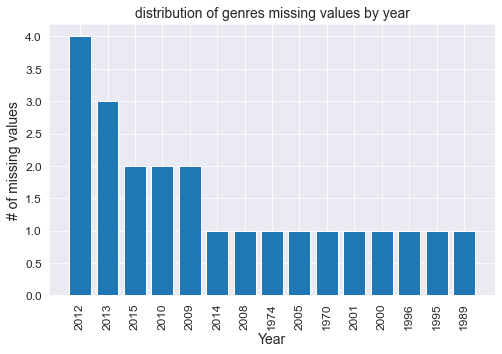

In [7]:
#filtering the missing values of genres and the corresponding release year
genre_null = df_mov[df_mov.genres.isnull()]['release_year'].value_counts()
# arranging the bars along the x-axis
ind = np.arange(len(genre_null))

plt.subplots(figsize=(8,5))

plt.bar(ind, genre_null)
plt.title('distribution of genres missing values by year', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('# of missing values', fontsize=14)
labels = genre_null.index.astype(str)
plt.xticks(ind, labels, rotation=90, fontsize=12)
plt.yticks(fontsize=12);

#### My thought proccess on handling missing data(cont.)
- As a final clarification, I would opt for filling in the missing data. But those are all string columns to be able to fill them with the mean. Maybe, I would have to employ a more advanved technique such as classification or inconveniently and/or unrealistically try to manually fill in the missing data.

### 2.3 assessing and removing outliers

First things first:
- displaying the shapes of the different columns in the dataset

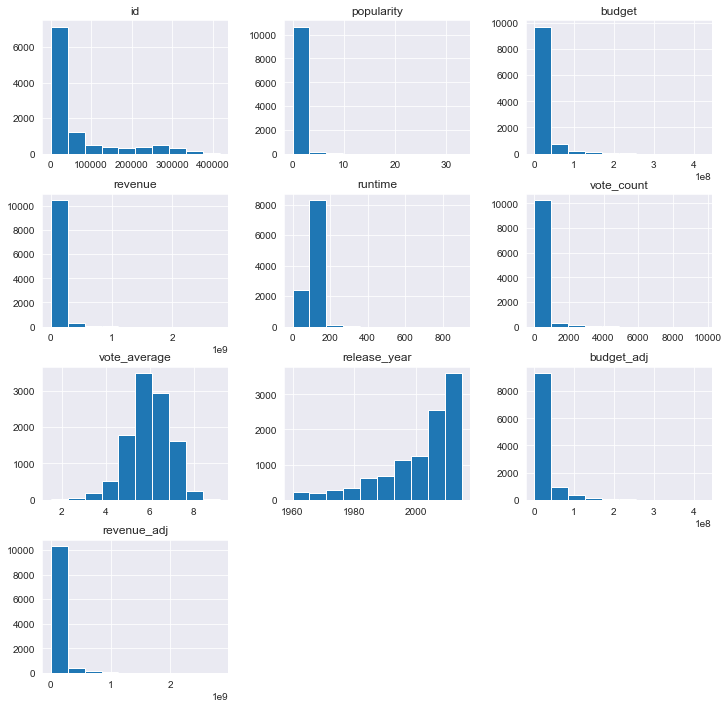

In [8]:
df_mov.hist(figsize=(12,12));

#### Interpreting some of the shapes displayed above:
- Distribution for vote averages is normally distributed which indicates that the vote averages are similar amongst different movies of **different** revenues.  
  
  
- Distribution for years of release appears to be skewed to the left which indicates that many movies in this dataset were released in more recent years.  
  
  
- Distribution for movies runtime is skewed to the right which indicate the presence of outlier(s) which in turn falsely increase the mean runtime.
 - one way to handle this, is to report the median runtime—since the median is immune to such outlier(s)— rather than the mean.
 - another way is to remove outliers using the 1.5 IQR rule  
   
     
- Distribution for revenue is skewed to the right which indicates that there are movies with higher revenue than most of the other movies in the dataset. However, those kind of outliers are what my first posed research question is dependent on and so, I am inclined to keep them. But, as for lower bound outliers such as zeros, they would skew certain types of calculation such as calculating proportions, since zeros do not contribute to the sum but rather to the count that we divide by in the denominator and give biased results when compared with different proportions.  
  
p.s. In the analysis of the first question later on in this notebook, I'm going to calculate proportion of revenue for all movies compared to proportion of top revenue movies

#### overview of outliers
- Initially, I'll use the median as the baseline to assess presence of outliers by filtering the dataset for rows where the revenue is less than its median since the revenue column is the most important feature for this analysis.

In [9]:
# Calcualting median of revenues
median = df_mov['revenue'].median()
median

0.0

since the above median is zero! I'm going to pull the rows where revenue is equal to the median and not less than it, since there are no negative values in the revenue column.

In [10]:
# filtering rows where revenue equals its median of zero
df_mov[df_mov['revenue'] == median]

,id,popularity,budget,revenue,original_title,runtime,genres,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
48,265208,2.932340,30000000,0,Wild Card,92,Thriller|Crime|Drama,1/14/15,481,5.3,2015,2.759999e+07,0.0
67,334074,2.331636,20000000,0,Survivor,96,Crime|Thriller|Action,5/21/15,280,5.4,2015,1.839999e+07,0.0
74,347096,2.165433,0,0,Mythica: The Darkspore,108,Action|Adventure|Fantasy,6/24/15,27,5.1,2015,0.000000e+00,0.0
75,308369,2.141506,0,0,Me and Earl and the Dying Girl,105,Comedy|Drama,6/12/15,569,7.7,2015,0.000000e+00,0.0
92,370687,1.876037,0,0,Mythica: The Necromancer,0,Fantasy|Action|Adventure,12/19/15,11,5.4,2015,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10861,21,0.080598,0,0,The Endless Summer,95,Documentary,6/15/66,11,7.4,1966,0.000000e+00,0.0
10862,20379,0.065543,0,0,Grand Prix,176,Action|Adventure|Drama,12/21/66,20,5.7,1966,0.000000e+00,0.0
10863,39768,0.065141,0,0,Beregis Avtomobilya,94,Mystery|Comedy,1/1/66,11,6.5,1966,0.000000e+00,0.0
10864,21449,0.064317,0,0,"What's Up, Tiger Lily?",80,Action|Comedy,11/2/66,22,5.4,1966,0.000000e+00,0.0


#### As seen above, there is a significant amount of zero values in the revenue column
Elaborating on the two points I wrote earlier—and to take my own advice!— in section 2.2 of this notebook—although, technically, zeros are not like NULLs, but luckily, the same principles still apply—
> 2. If the column was pivotal to my analysis and closely associated with another column of interest, I would suggest to drop the missing values, rather than completely dropping the column.
> 3. If dropping the missing values of the column in question affects the analysis of the other columns—especially for a small sample size—I would drop the column itself entirely from the dataset, or seperate it from the rest of the dataset to analyse it independently.  

- The first point describes this scenario well since the revenue column is the cornerstone of the first posed question:
> Characteristics associated with high revenue movies  

    and that it's closely related to other columns in this dataset. So based on this point, I would drop the lower bound values of the revenue column and the corresponding values of the other columns.  
      
        
        
- the second point seems to counter the first one but only because the genres and the release year columns are the cornerstones of the second posed question for this analysis:
> Which genres are most popular from year to year?  
  
    And since they're not related to the revenue column in the analysis of the second question, dropping rows in the genres and the release year columns that correspond with the lower bound values in the revenue column would affect the results of the second analysis.  
    As the second point's proposed solution which is to seperate it from the columns that could be affected, I'm going to make a copy of the original dataset to make it specific for the first type of analysis. 

#### removing outliers
- First, as discussed above, I'm going to make a copy of the original dataset.
- Second, I'm going to remove values of zero in the revenue column
- Third, I'm going to remove lower bound outliers based on the 1.5 IQR Rule.

In [11]:
# making copy of the original dataset
df_mov_copy = df_mov.copy()

In [12]:
# Removing all values of zero from the revenue column
df_mov_copy = df_mov_copy.loc[df_mov_copy['revenue'] > 0]
df_mov_copy

,id,popularity,budget,revenue,original_title,runtime,genres,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,32.985763,150000000,1513528810,Jurassic World,124,Action|Adventure|Science Fiction|Thriller,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,28.419936,150000000,378436354,Mad Max: Fury Road,120,Action|Adventure|Science Fiction|Thriller,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,13.112507,110000000,295238201,Insurgent,119,Adventure|Science Fiction|Thriller,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,11.173104,200000000,2068178225,Star Wars: The Force Awakens,136,Action|Adventure|Science Fiction|Fantasy,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,9.335014,190000000,1506249360,Furious 7,137,Action|Crime|Thriller,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10822,396,0.670274,7500000,33736689,Who's Afraid of Virginia Woolf?,131,Drama,6/21/66,74,7.5,1966,5.038511e+07,2.266436e+08
10828,5780,0.402730,3000000,13000000,Torn Curtain,128,Mystery|Thriller,7/13/66,46,6.3,1966,2.015404e+07,8.733419e+07
10829,6644,0.395668,4653000,6000000,El Dorado,120,Action|Western,12/17/66,36,6.9,1966,3.125892e+07,4.030809e+07
10835,5923,0.299911,12000000,20000000,The Sand Pebbles,182,Action|Adventure|Drama|War|Romance,12/20/66,28,7.0,1966,8.061618e+07,1.343603e+08


In [13]:
# removing lower bound outliers with the 1.5 IQR rule
q1 = df_mov_copy['revenue'].quantile(0.25) # getting first quartile
q3 = df_mov_copy['revenue'].quantile(0.75) # getting third quartile
iqr = q3 - q1 # Calculating the IQR
low_outlier = q1 - 1.5 * iqr # 1.5 IQR rule for low outliers
low_outlier

-130607148.25

In [14]:
# Filtering rows where the revenue is more than the low outlier threshold
mask = (df_mov_copy['revenue'] > low_outlier)
df_mov_copy = df_mov_copy.loc[mask]

Since there are no values crossing the low outlier threshold of -130607148.25! the dataset won't have changed

### Data Cleaning
#### along with the data cleaning and wrangling that took place in the above section, there remains checking for duplicate rows.
- For this kind of dataset, it doesn't seem to make sense keeping rows identical of all their features.
- And considering that there are large numbers like revenues, these being unnecessarily duplicated could give biased results when performing certain types of calculation.  

So, I'm going to drop rows with such characteristics.

In [15]:
# dropping rows with all the same features
df_mov.drop_duplicates(inplace=True)

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 (Characteristics associated with high revenue movies)

In [16]:
# criteria for top revenue movies with one-hundred million or more in revenue
top_revenue = df_mov_copy.query('revenue >= 1e08')

#### There is a weak and positive linear relationship between budget and revenue
#### provieded with the assumption that there might be a strong relationship between budget and revenue, this scatter plot below shows that there is actually a weak correlation between these two variables

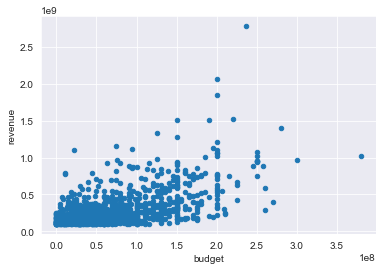

In [17]:
# looking for correlation of the two variables in the top revenue movies
top_revenue.plot(kind='scatter', x='budget', y='revenue');

In [18]:
# calculating the Pearson correlation coeffecient for the scatter plot above
r = top_revenue[['budget', 'revenue']].corr(method='pearson', min_periods=1)
r

,budget,revenue
budget,1.000000,0.586141
revenue,0.586141,1.000000


#### Similar to the coefficient of determination, although this is merely to find the difference of revenues between the two distributions
- Despite the fact that the dataset for all the movies is larger than the dataset of high revenue movies,  approximately, 78% of the total revenue of all the movies is described by the total revenue in the top revenue movies

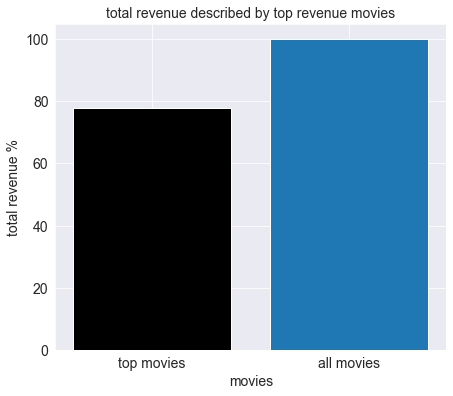

In [19]:
x, y = top_revenue.revenue.sum(), df_mov_copy.revenue.sum() # total revenues for both datasets
described = ((1-((y - x) / y)) * 100).round() # the formula for coefficient of determination

plt.subplots(figsize=(7,6))

plt.bar('top movies', described, color='black')
plt.bar('all movies', 100) # setting up the y-scale to 100%

plt.title('total revenue described by top revenue movies', fontsize=14)
plt.xlabel('movies', fontsize=14)
plt.ylabel('total revenue %', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Alternatively, proportions of high revenue movies and total revenue of all movies
#### Proportion revenue of top revenue movies is significantly higher than proportion of revenue of all the movies

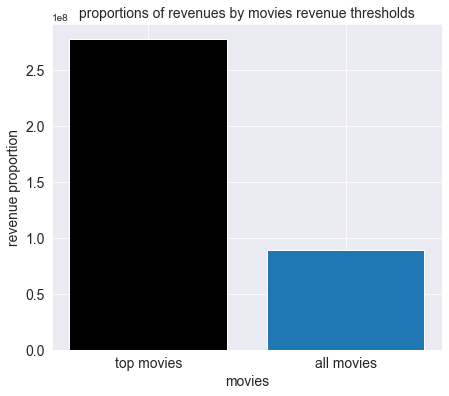

In [20]:
top_total = top_revenue.shape[0]
all_total = df_mov_copy.shape[0]
top_proportion = x/top_total
all_proportion = y/all_total

plt.subplots(figsize=(7,6))

plt.bar('top movies', top_proportion, color='black')
plt.bar('all movies', all_proportion)

plt.title('proportions of revenues by movies revenue thresholds', fontsize=14)
plt.xlabel('movies', fontsize=14)
plt.ylabel('revenue proportion', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

#### To test out the assumption that high revenue movies should be associated with higher budget and to get an idea of what the median revenue in a dataset of high revenue movies is, I have provided the following statistics.
Note(s):
> A ROI estimate of the movies can be extrapolated with these statistics for the revenue and budget features  

> as a fun fact—a fact specific to this dataset at least—The median runtime for high revenue movies is an hour and 52 minutes(112 minutes).

In [21]:
top_revenue.describe().loc[['50%', 'min', 'max', 'std', 'mean'], ['budget', 'revenue', 'runtime']]

,budget,revenue,runtime
50%,5.840000e+07,1.949164e+08,112.000000
min,0.000000e+00,1.000000e+08,72.000000
max,3.800000e+08,2.781506e+09,705.000000
std,5.425897e+07,2.356878e+08,26.876157
mean,7.036850e+07,2.779253e+08,115.309406


#### There is a clear trend suggesting a progressive decade-by-decade increase in movies revenue

#### Note(s):
> As the years go by, movies seem to increase in revenue. This is a relationship which might not be possible to accuretly identify its origin with merely the kinds of features provided in this dataset. And this could be accounted as a limitation in the availability of data at hand.

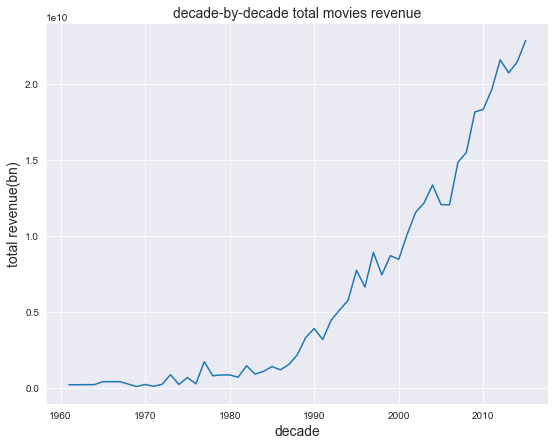

In [22]:
rev_by_year = top_revenue.groupby('release_year')['revenue'].sum()
plt.subplots(figsize=(9,7))
plt.plot(rev_by_year)
plt.title('decade-by-decade total movies revenue', fontsize=14)
plt.xlabel('decade', fontsize=14)
plt.ylabel('total revenue(bn)', fontsize=14);

### Research Question 2  (most popular genres from year to year)

In [23]:
grouped = df_mov.groupby('release_year')['genres']

In [24]:
def most_popular(groups):
    genres_dictionary = dict()
    for index, grouping in groups:
        genres = []
        for row in grouping:
            if isinstance(row, str): # bypassing null and other data types beside strings
                for genre in row.split('|'):
                    genres.append(genre) 
            else:
                continue
        genres = pd.Series(genres).value_counts() # Converting list to series to perform series-related operations
        genres_dictionary[index] = np.sort(np.array(genres.index[:3])) # Getting and sorting alphabetically the top three genres for each year
    genres_df = pd.DataFrame(genres_dictionary) # Converting to dataframe for final display
    return genres_df

#### A lot of the years are associated with the movie genres Comedy, Drama, and Thriller
Note(s):
> A range of 10 years—from 2005 to 2015—years of release share the same top genres for their respective movies.

In [25]:
top_df = most_popular(grouped)
top_df

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Action,Comedy,Action,Comedy,Comedy,Action,Action,Comedy,Comedy,Action,Action,Action,Action,Crime,Crime,Comedy,Action,Action,Drama,Comedy,Action,Drama,Comedy,Comedy,Action,Action,Comedy,Action,Comedy,Action,Comedy,Action,Comedy,Action,Action,Comedy,Comedy,Comedy,Comedy,Comedy,Comedy,Comedy,Comedy,Action,Action,Comedy,Comedy,Comedy,Comedy,Comedy,Comedy,Comedy,Comedy,Comedy,Comedy,Comedy
1,Comedy,Drama,Adventure,Drama,Crime,Drama,Comedy,Drama,Drama,Comedy,Comedy,Drama,Comedy,Drama,Drama,Drama,Drama,Adventure,Horror,Drama,Drama,Horror,Drama,Drama,Comedy,Comedy,Drama,Comedy,Drama,Comedy,Drama,Comedy,Drama,Comedy,Comedy,Drama,Drama,Drama,Drama,Drama,Drama,Drama,Drama,Comedy,Comedy,Drama,Drama,Drama,Drama,Drama,Drama,Drama,Drama,Drama,Drama,Drama
2,Drama,Romance,Drama,Thriller,Drama,Thriller,Drama,Romance,Romance,Drama,Drama,Thriller,Drama,Thriller,Thriller,Thriller,Thriller,Drama,Thriller,Thriller,Thriller,Thriller,Horror,Thriller,Drama,Drama,Horror,Drama,Horror,Drama,Thriller,Drama,Thriller,Drama,Drama,Thriller,Thriller,Thriller,Thriller,Thriller,Thriller,Thriller,Thriller,Drama,Drama,Thriller,Thriller,Thriller,Thriller,Thriller,Thriller,Thriller,Thriller,Thriller,Thriller,Thriller


## Conclusions
- No indication of correlation between higher budget and higher revenue
- Almost four-fifths the total revenue of all the movies is accounted for by the top revenue movies
- Proportion revenue of top revenue movies is significantly higher than proportion of revenue of all the movies
- top revenue movies seem to be correlated with a median runtime of 112 minutes; median revenue of approximately 195 million; a median budget of approximately 58 million.
- Movies revenue generally increase as the years go by
- Many years of release seem to be correlated with the same type of genre  
  
## Limitations
- The relationship between higher revenue movies and more recent years isn't possible to accurately understand the reason behind it with merely the kinds of features provided in this dataset. this could be accounted as a limitation in the availability of data at hand.  
  
  
- the scale for the popularity feature in this dataset isn't known, and thus, it would be hard to identify the criteria for popular movies and/or being able to identify outliers for this particular feature of the dataset. this could account for limitations in the quality of the data at hand.

## External Sources
- Websites: N/A
- Books: N/A
- Forums: N/A
- Blog posts: N/A
- github repositories: N/A
- other: N/A